# Multiresolution Hash Encoding

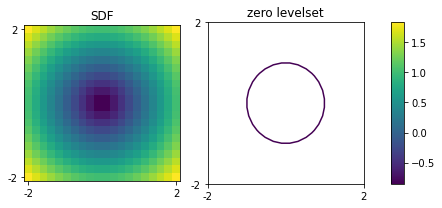

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.config import config
config.update("jax_enable_x64", True)  # TODO how to embrace int32 overflow for hashing in JAX?
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import functools as ft
import optax
import treex as tx
from sdf_jax import plot2d, discretize2d
from sdf_jax import SimpleNeuralSDF, train_step


def sdf_sphere(x):
    return jnp.linalg.norm(x) - 1

plot2d(sdf_sphere, ngrid=20)

## Benchmark Multiresolution Hash Enconding

In [2]:
import hash_encoding
# x = jnp.array([1.1, 2.2, 1.3])
x = jnp.array([1.1, 2.2])
key = jrandom.PRNGKey(1234)
key, theta_key = jrandom.split(key, 2)
theta = hash_encoding.init_encoding(theta_key)
theta.shape

(16, 16384, 2)

In [3]:
hash_encoding.encode(x, theta).block_until_ready()

DeviceArray([[-5.02064431e-05, -3.78377564e-05],
             [ 2.09385879e-05, -7.26148374e-05],
             [-5.44960162e-05, -3.84142273e-05],
             [ 3.74598273e-05,  4.70688338e-05],
             [ 1.87281665e-06,  9.01920669e-05],
             [-6.58134153e-05, -6.18476603e-05],
             [-1.63026143e-05,  3.98630744e-06],
             [-4.74615360e-05,  3.69736602e-05],
             [-6.68170620e-05,  1.48532401e-05],
             [ 4.88814254e-06,  3.70853059e-05],
             [-5.74407955e-05, -5.06138501e-05],
             [ 2.37758160e-06, -1.05089996e-05],
             [ 6.40706054e-06,  3.12502505e-05],
             [-2.93182706e-05,  2.58453747e-05],
             [-3.32286563e-06, -3.38646269e-05],
             [-3.75017244e-05, -2.83093781e-05]], dtype=float64)

In [4]:
%timeit hash_encoding.encode(x, theta).block_until_ready()

8.89 µs ± 940 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [5]:
@jax.jit
def encode_batch(x, theta):
    return jax.vmap(lambda x: hash_encoding.encode(x, theta))(x)

key, xs_key = jrandom.split(key, 2)
xs = jrandom.uniform(xs_key, (1_000_000, 3))
encode_batch(xs, theta).shape

(1000000, 16, 2)

In [6]:
%timeit encode_batch(xs, theta).block_until_ready()

1.16 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
xs = jrandom.uniform(xs_key, (1_000_000, 2))
%timeit encode_batch(xs, theta).block_until_ready()

465 ms ± 9.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Use in SDF

In [17]:
class HashEmbedding(tx.Module):
    theta: jnp.ndarray = tx.Parameter.node()

    def __init__(
        self, 
        levels: int=16, 
        hashmap_size_log2: int=14, 
        features_per_entry: int=2,
    ):
        self.levels = levels
        self.hashmap_size_log2 = hashmap_size_log2
        self.features_per_entry = features_per_entry

    def __call__(self, x):
        assert x.ndim == 1
        if self.initializing():
            hashmap_size = 1 << self.hashmap_size_log2
            key = tx.next_key()
            self.theta = jrandom.uniform(
                key, 
                (self.levels, hashmap_size, self.features_per_entry), 
                minval=-0.0001, 
                maxval=0.0001
            )
        
        return hash_encoding.encode(x, self.theta).reshape(-1)

emb = HashEmbedding().init(key=42, inputs=x)
emb(x).shape

(32,)

In [33]:
model = tx.Sequential(
    HashEmbedding(),
    tx.Linear(64),
    jax.nn.softplus,
    tx.Linear(1),
    lambda x: x[0]
).init(key=42, inputs=x)
model(x)

DeviceArray(0.19099818, dtype=float32)

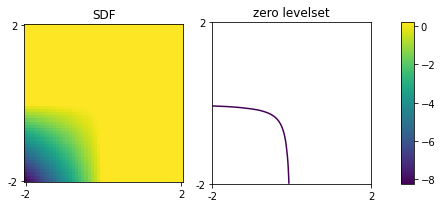

In [34]:
plot2d(model, ngrid=50)

  0%|          | 0/2000 [00:00<?, ?it/s]

[0] loss: 2.0474
[200] loss: 0.6346
[400] loss: 1.3385
[600] loss: 2.0057
[800] loss: 1.9099
[1000] loss: 0.5920
[1200] loss: 1.0846
[1400] loss: 0.8798
[1600] loss: 0.7223
[1800] loss: 0.6475


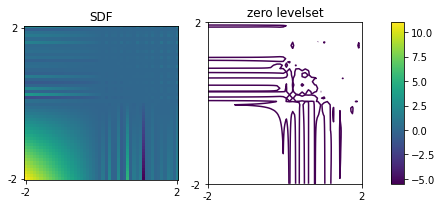

In [49]:
from sdf_jax import train_step, print_callback
from tqdm.notebook import tqdm

def fit(
    sdf=sdf_sphere,
    xy_lims=(-2, 2),
    ngrid=20,
    # module
    act=jax.nn.relu,
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    # utils
    cb=print_callback,
    cb_every=10,
):
    xs, ys = discretize2d(sdf, xy_lims=xy_lims, ngrid=ngrid)
    xs = xs.reshape(-1, 2)
    ys = ys.reshape(-1)
    key, model_key = jrandom.split(key, 2)
    model = tx.Sequential(
        HashEmbedding(),
        tx.Linear(64),
        act,
        tx.Linear(64),
        act,
        tx.Linear(1),
        lambda x: x[0]
    ).init(key=model_key, inputs=xs[0])
    optimizer = tx.Optimizer(optax.adam(lr, b1=0.9, b2=0.99, eps=1e-15))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    for step in tqdm(range(steps)):
        loss, model, optimizer = train_step(model, xs, ys, optimizer)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    return loss, model

loss, model = fit(lr=1e-4, steps=2000, cb_every=200)
plot2d(model, ngrid=50)

  0%|          | 0/500 [00:00<?, ?it/s]

[0] loss: 0.8692
[100] loss: 0.3850
[200] loss: 0.0668
[300] loss: 0.0107
[400] loss: 0.0031


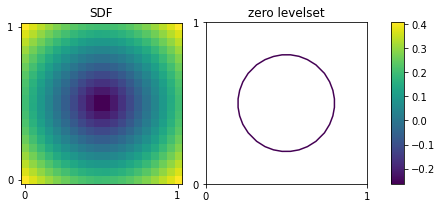

In [59]:
# it seems coordinates matter a lot.
# is the unit square a default assumption ?
# TODO investigate / think

def sdf_sphere2(x):
    center = np.array([0.5, 0.5])
    radius = 0.3
    return jnp.linalg.norm(x - center) - radius

loss, model = fit(
    sdf_sphere2, 
    xy_lims=(0,1),
    lr=1e-4, 
    steps=500, 
    cb_every=100,
)
plot2d(model, ngrid=20, xy_lims=(0,1))

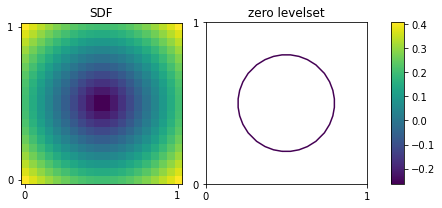

In [62]:
plot2d(sdf_sphere2, ngrid=20, xy_lims=(0,1))